<a href="https://colab.research.google.com/github/MarshaKamsteeg/TM10007_Machine_Learning_Group_Assignment/blob/main/tm10007_group_9_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TM10007 Assignment

In [ ]:
# Run this to use from colab environment
!pip install -q --upgrade git+https://github.com/karinvangarderen/tm10007_project.git

## Description of data set
Import data from the ADNI dataset. Find empty values if present. 

In [ ]:
# Import Data
from adni.load_data import load_data
import numpy as np
import pandas as pd

# Import Data
data = load_data()
data_pandas = pd.DataFrame(data)
print(f'Total number of samples: {len(data.index)}')
print(f'Total number of columns: {len(data.columns)}')
print(f'Total amount of features: {len(data.columns)-2}')

# Find empty / NaN entry in pandas dataframe
data_pandas = data_pandas.replace(' ', np.nan) 
empty_values = np.where(pd.isnull(data_pandas))

if ~empty_values[0] == []:
  print(f'Empty values can be found at index {empty_values}')
else:
  print('There are no empty values found.')
  pass

# Percentage AD and CN
number_AD = data_pandas['label'].value_counts()['AD']
number_CN = data_pandas['label'].value_counts()['CN']
print(f"Within the dataset {number_AD} samples are from people with Alzheimer Disease")
print(f"The other {number_CN} samples are from people without Alzheimer Disease") 


Total number of samples: 855
Total number of columns: 268
Total amount of features: 266
There are no empty values found.
Within the dataset 519 samples are from people with Alzheimer Disease
The other 336 samples are from people without Alzheimer Disease


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


# Preprocessing of the data

## Dividing data in a designset (80%) and testset (20%)

In [ ]:
# import modules
from sklearn.model_selection import train_test_split

# Divide data in label and feature set 
labels = data['label']
features = data.drop(columns=['label'])

# Divide data in trainingsset (80%) and testset (20%) stratified for the label
data_designset, data_testset, label_designset, label_testset = train_test_split(features, labels, test_size=.2, random_state=1, stratify=data['label'])

# Check the stratification 
percent_AD_train = (label_designset.value_counts()['AD'])/len(label_designset)*100
percent_CN_train = (label_designset.value_counts()['CN'])/len(label_designset)*100
percent_AD_test = (label_testset.value_counts()['AD'])/len(label_testset)*100
percent_CN_test = (label_testset.value_counts()['CN'])/len(label_testset)*100

print(f"{percent_AD_train:.2f}% of the train data are Alzheimer disease samples.")
print(f"{percent_CN_train:.2f}% of the train data are control samples.")
print(f"{percent_AD_test:.2f}% of the test data are Alzheimer disease samples.")
print(f"{percent_CN_test:.2f}% of the test data are control samples.")


60.67% of the train data are Alzheimer disease samples.
39.33% of the train data are control samples.
60.82% of the test data are Alzheimer disease samples.
39.18% of the test data are control samples.


## Feature Dropping

Find columns where > 90% of the column has value zero. Remove the features if this is true. Besides, remove features if the whole column has one unique value. 

In [ ]:
data_designset = data_designset.drop(columns=data_designset.columns[data_designset.eq(0).mean()>0.9])
data_designset = data_designset[data_designset.columns[data_designset.nunique() > 1]]
data_designset_feature_names = data_designset.columns

# Eventueel verwijderen als meer dan 90% hetzelfde is. 
# Toevoegen welke kolom die verwijdert.

## Scaling

In [ ]:
# Different methods for feature scaling. Decision will be made after usage of PCA
# Import modules
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

# # Robust scaler - based on percentiles. Not influenced by a few number of very large marginal outliers
# trans = RobustScaler()
# x_train_robust = trans.fit_transform(x_train)

# # Standard scaler - removes the mean and scales the data to unit variance
# scaler = StandardScaler()
# x_train_scaler = scaler.fit_transform(x_train)

# MinMax scaler - rescales data set such that all feature values are in range [0,1]
norm = MinMaxScaler().fit(data_designset)
data_designset_norm = norm.transform(data_designset)
data_designset_norm = pd.DataFrame(data_designset_norm)
data_designset_norm.columns = data_designset_feature_names

# Cross validation
First a stratified k fold cross validation is used with 10 splits. 
Feature selection - best method to select features from this multi feature space. The options looked in to are:
1. Univariate
2. Univariate + PCA
3. PCA

Classifier - best classifier with the remaining features. Three classifiers are looked in to based on literature review.
1. K-NN (normalized scaler)
2. SVM 
3. CNN

# Univariate optimalisatie beide

In [ ]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import StratifiedKFold, GridSearchCV, StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn import neighbors, metrics
import seaborn
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, f_classif
import math

# configure the cross-validation procedure. A 10 fold split is used stratified for the label. 
sss = StratifiedShuffleSplit(n_splits = 10, test_size = 0.1, random_state=1)
k_list = list(range(1, 50, 2))

threshold = []
mean_auc_val = []
std_auc_val = []
optimal_k = []

thresholds = np.linspace(0,1,11)
for threshold_feature_relative in thresholds:
  all_train = []
  all_val = []
  results = []
  best_n_neighbors = []


  for train_idx, val_idx in sss.split(data_designset_norm,label_designset): # split data
    x_train, x_val = data_designset_norm.to_numpy()[train_idx], data_designset_norm.to_numpy()[val_idx]
    y_train, y_val = label_designset.to_numpy()[train_idx], label_designset.to_numpy()[val_idx]

    train_scores = []
    val_scores = []

    # Feature selection using univariate statistical testing. An one-way ANOVA is used and the features are scored. 
    bestfeatures = SelectKBest(score_func=f_classif, k=len(data_designset_norm.columns))
    fit = bestfeatures.fit(x_train, y_train)
    dfscores = pd.DataFrame(fit.scores_)
    dfcolumns = pd.DataFrame(data_designset_norm.columns)


    feature_scores = pd.concat([dfcolumns,dfscores],axis=1)
    feature_scores.columns = ['Specs','Score']  
    feature_scores = feature_scores.sort_values('Score')
    highest_feature_score = feature_scores['Score'].iloc[-1]
    # threshold_feature_relative = 0.5                                                 # Optimization of parameter is needed
    threshold_feature_score = threshold_feature_relative*highest_feature_score

    # Every feature scoring above the threshold will be selected. 
    feature_selection_names = []
    for i in range(0,len(feature_scores['Score'])):
      if feature_scores['Score'].iloc[i]>=threshold_feature_score:
        feature_selection_names.append(feature_scores['Specs'].iloc[i])

    selected_data_univ_designset_norm = data_designset_norm[feature_selection_names]
    selected_data_univ_trainset_norm = selected_data_univ_designset_norm.to_numpy()[train_idx]
    selected_data_univ_valset_norm = selected_data_univ_designset_norm.to_numpy()[val_idx]
    
    # Aplly K-Nearest Neighbor classifier to features selected with univariate
    for k in k_list: 
      clf_knn = neighbors.KNeighborsClassifier(n_neighbors=k)
      clf_knn.fit(selected_data_univ_trainset_norm, y_train)

      # Test the classifier on the selected features from the training data and plot 
      train_proba = clf_knn.predict_proba(selected_data_univ_trainset_norm)[:,1]
      val_proba = clf_knn.predict_proba(selected_data_univ_valset_norm)[:,1]

      score_train = metrics.roc_auc_score(y_train, train_proba)
      score_val = metrics.roc_auc_score(y_val, val_proba)

      train_scores.append(score_train)
      val_scores.append(score_val)

    all_train.append(train_scores)
    all_val.append(val_scores)

    # Create a grid search to find the optimal k using a gridsearch and 10-fold cross validation
    # Same as above
    parameters = {"n_neighbors": list(range(1, 26, 2))}
    knn = neighbors.KNeighborsClassifier()
    cv_10fold = StratifiedKFold(n_splits=10)
    grid_search = GridSearchCV(knn, parameters, cv=cv_10fold, scoring='roc_auc')
    grid_search.fit(selected_data_univ_trainset_norm, y_train)
    
    # Get resulting classifier
    clf = grid_search.best_estimator_
    print(f'Best classifier: k={clf.n_neighbors}')
    best_n_neighbors.append(clf.n_neighbors)
    
    # Test the classifier on the test data
    probabilities = clf.predict_proba(selected_data_univ_valset_norm)
    scores = probabilities[:, 1]
    
    # Get the auc
    auc = metrics.roc_auc_score(y_val, scores)
    results.append({
        'auc': auc,
        'k': clf.n_neighbors,
        'set': 'validation'
    })
    print(auc)
    
    # Test the classifier on the validation data
    probabilities_train = clf.predict_proba(selected_data_univ_trainset_norm)
    scores_train = probabilities_train[:, 1]
    
    # Get the auc
    auc_train = metrics.roc_auc_score(y_train, scores_train)
    results.append({
        'auc': auc_train,
        'k': clf.n_neighbors,
        'set': 'train'
    })
    
  # Calculate the mean and std
  all_train = np.array(all_train)
  all_val = np.array(all_val)

  train_scores_mean = all_train.mean(axis=0)
  val_scores_mean = all_val.mean(axis=0)

  train_scores_std = all_train.std(axis=0)
  val_scores_std = all_val.std(axis=0)

  # Plot the mean scores and the std as shading
  fig = plt.figure(figsize=(8,8))
  ax = fig.add_subplot(111)
  ax.grid()
  ax.fill_between(k_list, train_scores_mean - train_scores_std,
                      train_scores_mean + train_scores_std, alpha=0.1,
                      color="r")
  ax.fill_between(k_list, val_scores_mean - val_scores_std,
                      val_scores_mean + val_scores_std, alpha=0.1,
                      color="g")
  ax.plot(k_list, train_scores_mean, 'o-', color="r",
          label="Training score")
  ax.plot(k_list, val_scores_mean, 'o-', color="g",
          label="Validation score")
  
  # Create results dataframe and plot it
  plt.figure()
  results = pd.DataFrame(results)
  seaborn.boxplot(y='auc', x='set', data=results)

  auc_val = results[results['set'].str.contains('validation')]
  threshold.append(threshold_feature_relative)
  mean_auc_val.append(auc_val['auc'].mean())
  std_auc_val.append(auc_val['auc'].std())
  optimal_k.append(int(np.median(best_n_neighbors)))

  optimal_n = int(np.median(best_n_neighbors))
  print(f"The optimal N={optimal_n}")

auc_table = {'Threshold': threshold, 'Mean AUC': mean_auc_val, 'Standard deviation AUC': std_auc_val, 'Optimal k': optimal_k}
print(tabulate(auc_table, headers='keys', tablefmt='fancy_grid'))


Best classifier: k=23
0.876984126984127
Best classifier: k=23
0.7888007054673721
Best classifier: k=23
0.8977072310405643


KeyboardInterrupt: ignored

# Univariate waar we al optimale threshold van 0.5

Best classifier: k=21
Best classifier: k=19
Best classifier: k=21
Best classifier: k=19
Best classifier: k=23
Best classifier: k=23
Best classifier: k=21
Best classifier: k=23
Best classifier: k=23
Best classifier: k=19
The optimal N=21


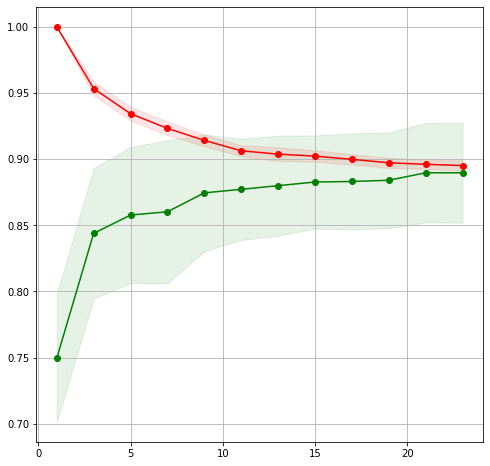

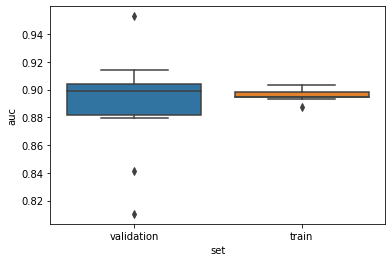

In [ ]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import StratifiedKFold, GridSearchCV, StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn import neighbors, metrics
import seaborn
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, f_classif
import math

# configure the cross-validation procedure. A 10 fold split is used stratified for the label. 
sss = StratifiedShuffleSplit(n_splits = 10, test_size = 0.1, random_state=1)
k_list = list(range(1, 25, 2))

all_train = []
all_val = []
results = []
best_n_neighbors = []

for train_idx, val_idx in sss.split(data_designset_norm,label_designset): # split data
  x_train, x_val = data_designset_norm.to_numpy()[train_idx], data_designset_norm.to_numpy()[val_idx]
  y_train, y_val = label_designset.to_numpy()[train_idx], label_designset.to_numpy()[val_idx]

  train_scores = []
  val_scores = []

  # Feature selection using univariate statistical testing. An one-way ANOVA is used and the features are scored. 
  bestfeatures = SelectKBest(score_func=f_classif, k=len(data_designset_norm.columns))
  fit = bestfeatures.fit(x_train, y_train)
  dfscores = pd.DataFrame(fit.scores_)
  dfcolumns = pd.DataFrame(data_designset_norm.columns)

  # A threshold is set on 0.5 times the maximum scoring feature.
  feature_scores = pd.concat([dfcolumns,dfscores],axis=1)
  feature_scores.columns = ['Specs','Score']  
  feature_scores = feature_scores.sort_values('Score')
  highest_feature_score = feature_scores['Score'].iloc[-1]
  threshold_feature_relative = 0.5                                                 # Optimization of parameter is needed
  threshold_feature_score = threshold_feature_relative*highest_feature_score

  # Every feature scoring above the threshold will be selected. 
  feature_selection_names = []
  for i in range(0,len(feature_scores['Score'])):
    if feature_scores['Score'].iloc[i]>=threshold_feature_score:
      feature_selection_names.append(feature_scores['Specs'].iloc[i])

  selected_data_designset_norm = data_designset_norm[feature_selection_names]
  selected_data_trainset_norm = selected_data_designset_norm.to_numpy()[train_idx]
  selected_data_valset_norm = selected_data_designset_norm.to_numpy()[val_idx]
  
  for k in k_list: 
    clf_knn = neighbors.KNeighborsClassifier(n_neighbors=k)
    clf_knn.fit(selected_data_trainset_norm, y_train)

    # Test the classifier on the selected features from the training data and plot 
    train_proba = clf_knn.predict_proba(selected_data_trainset_norm)[:,1]
    val_proba = clf_knn.predict_proba(selected_data_valset_norm)[:,1]

    score_train = metrics.roc_auc_score(y_train, train_proba)
    score_val = metrics.roc_auc_score(y_val, val_proba)

    train_scores.append(score_train)
    val_scores.append(score_val)

  all_train.append(train_scores)
  all_val.append(val_scores)

  # Create a grid search to find the optimal k using a gridsearch and 10-fold cross validation
  # Same as above
  parameters = {"n_neighbors": list(range(1, 26, 2))}
  knn = neighbors.KNeighborsClassifier()
  cv_10fold = StratifiedKFold(n_splits=10)
  grid_search = GridSearchCV(knn, parameters, cv=cv_10fold, scoring='roc_auc')
  grid_search.fit(selected_data_trainset_norm, y_train)
  
  # Get resulting classifier
  clf = grid_search.best_estimator_
  print(f'Best classifier: k={clf.n_neighbors}')
  best_n_neighbors.append(clf.n_neighbors)
  
  # Test the classifier on the test data
  probabilities = clf.predict_proba(selected_data_valset_norm)
  scores = probabilities[:, 1]
  
  # Get the auc
  auc = metrics.roc_auc_score(y_val, scores)
  results.append({
      'auc': auc,
      'k': clf.n_neighbors,
      'set': 'validation'
  })
  
  # Test the classifier on the validation data
  probabilities_train = clf.predict_proba(selected_data_trainset_norm)
  scores_train = probabilities_train[:, 1]
  
  # Get the auc
  auc_train = metrics.roc_auc_score(y_train, scores_train)
  results.append({
      'auc': auc_train,
      'k': clf.n_neighbors,
      'set': 'train'
  })

# Calculate the mean and std of the accuracy
all_train = np.array(all_train)
all_val = np.array(all_val)

train_scores_mean = all_train.mean(axis=0)
val_scores_mean = all_val.mean(axis=0)

train_scores_std = all_train.std(axis=0)
val_scores_std = all_val.std(axis=0)

# Plot the mean scores and the std as shading
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
ax.grid()
ax.fill_between(k_list, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1,
                    color="r")
ax.fill_between(k_list, val_scores_mean - val_scores_std,
                    val_scores_mean + val_scores_std, alpha=0.1,
                    color="g")
ax.plot(k_list, train_scores_mean, 'o-', color="r",
        label="Training score")
ax.plot(k_list, val_scores_mean, 'o-', color="g",
        label="Validation score")

# Create results dataframe and plot it
plt.figure()
results = pd.DataFrame(results)
seaborn.boxplot(y='auc', x='set', data=results)

optimal_n = int(np.median(best_n_neighbors))
print(f"The optimal N={optimal_n}")
  

### Univariate Feature Selection - BASIS

In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif
import matplotlib.pyplot as plt
import math 

bestfeatures = SelectKBest(score_func=f_classif, k=len(data_designset_norm.columns))
fit = bestfeatures.fit(data_designset_norm, label_designset)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(data_designset_norm.columns)

feature_scores = pd.concat([dfcolumns,dfscores],axis=1)
feature_scores.columns = ['Specs','Score']  
feature_scores = feature_scores.sort_values('Score')
highest_feature_score = feature_scores['Score'].iloc[-1]
threshold_feature_relative = 0.7                                                  # Optimization of parameter is needed
threshold_feature_score = threshold_feature_relative*highest_feature_score
criteria = feature_scores['Score']>=threshold_feature_score

feature_selection_names = []
for i in range(0,len(feature_scores['Score'])):
  if feature_scores['Score'].iloc[i]>=threshold_feature_score:
    feature_selection_names.append(feature_scores['Specs'].iloc[i])

selected_data_designset_norm = data_designset_norm[feature_selection_names]

# print(feature_scores.nlargest(50,'Score'))  


# PCA - BASIS

In [ ]:
# General Import
from sklearn.decomposition import PCA

# Create a PCA which retains n principle components
n_pca = 5
pca = PCA(n_components=n_pca)

# Fit the PCA model, point_data_train should be a 2D numpy array
# which has one row per subject and the pointdata as columns where
# the columns are x1, y1, z1, x2, y2, z2, ..., xn, yn, zn
pca.fit(x_train)

# Transform data
selected_data_trainset_trans = pca.transform(x_train)
print(data_trainset_trans)

[[-0.4240283   0.69619987  0.75375089 -0.13412269 -0.88390469]
 [-0.88516757 -0.6048795  -0.43968825  0.23650873 -0.13161926]
 [-1.32839282 -1.18676818 -0.71593989  0.37403718 -0.19717475]
 ...
 [-0.87393793  2.06784419  0.20802999  1.72922291  0.23744782]
 [-0.70226101  1.11946552  1.42546138 -0.81896458 -0.35024505]
 [-0.54073193 -0.02707676  0.06449632 -0.34814736  0.22938564]]


## PCA with KNN

Best classifier: k=23
Best classifier: k=25
Best classifier: k=23
Best classifier: k=23
Best classifier: k=21
Best classifier: k=25
Best classifier: k=21
Best classifier: k=25
Best classifier: k=25
Best classifier: k=23
The optimal N=23
Best classifier: k=25
Best classifier: k=21
Best classifier: k=25
Best classifier: k=23
Best classifier: k=21
Best classifier: k=23
Best classifier: k=25
Best classifier: k=25
Best classifier: k=25
Best classifier: k=23
The optimal N=24
Best classifier: k=23
Best classifier: k=25
Best classifier: k=25
Best classifier: k=23
Best classifier: k=25
Best classifier: k=19
Best classifier: k=23
Best classifier: k=23
Best classifier: k=25
Best classifier: k=25
The optimal N=24
Best classifier: k=23
Best classifier: k=21
Best classifier: k=23
Best classifier: k=23
Best classifier: k=23
Best classifier: k=19
Best classifier: k=25
Best classifier: k=25
Best classifier: k=25
Best classifier: k=25
The optimal N=23
Best classifier: k=25
Best classifier: k=21
Best cla

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:116: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:131: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Best classifier: k=25
Best classifier: k=23
Best classifier: k=23
Best classifier: k=23
Best classifier: k=23
Best classifier: k=23
Best classifier: k=25
Best classifier: k=25
Best classifier: k=25
Best classifier: k=25
The optimal N=24


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:116: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:131: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Best classifier: k=25
Best classifier: k=25
Best classifier: k=23
Best classifier: k=23
Best classifier: k=23
Best classifier: k=25
Best classifier: k=25
Best classifier: k=25
Best classifier: k=23
Best classifier: k=23
The optimal N=24


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:116: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:131: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Best classifier: k=25
Best classifier: k=25
Best classifier: k=25
Best classifier: k=23
Best classifier: k=25
Best classifier: k=23
Best classifier: k=25
Best classifier: k=25
Best classifier: k=23
Best classifier: k=25
The optimal N=25


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:116: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:131: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Best classifier: k=23
Best classifier: k=25
Best classifier: k=25
Best classifier: k=23
Best classifier: k=25
Best classifier: k=23
Best classifier: k=25
Best classifier: k=21
Best classifier: k=25
Best classifier: k=25


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:116: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:131: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


The optimal N=25
Best classifier: k=23
Best classifier: k=23
Best classifier: k=25
Best classifier: k=21
Best classifier: k=23
Best classifier: k=23
Best classifier: k=23
Best classifier: k=19
Best classifier: k=25
Best classifier: k=25
The optimal N=23


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:116: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:131: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Best classifier: k=25
Best classifier: k=25
Best classifier: k=19
Best classifier: k=23
Best classifier: k=21
Best classifier: k=23
Best classifier: k=23
Best classifier: k=25
Best classifier: k=23
Best classifier: k=25
The optimal N=23


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:116: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:131: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Best classifier: k=23
Best classifier: k=21
Best classifier: k=25
Best classifier: k=23
Best classifier: k=19
Best classifier: k=25
Best classifier: k=23
Best classifier: k=25
Best classifier: k=25
Best classifier: k=25
The optimal N=24


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:116: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:131: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Best classifier: k=25
Best classifier: k=23
Best classifier: k=23
Best classifier: k=23
Best classifier: k=21
Best classifier: k=23
Best classifier: k=25
Best classifier: k=25
Best classifier: k=25
Best classifier: k=25
The optimal N=24


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:116: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:131: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Best classifier: k=25
Best classifier: k=23
Best classifier: k=23
Best classifier: k=21
Best classifier: k=25
Best classifier: k=21
Best classifier: k=25
Best classifier: k=25
Best classifier: k=25
Best classifier: k=25
The optimal N=25


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:116: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:131: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Best classifier: k=25
Best classifier: k=23
Best classifier: k=25
Best classifier: k=23
Best classifier: k=25
Best classifier: k=21
Best classifier: k=25
Best classifier: k=23
Best classifier: k=23
Best classifier: k=17
The optimal N=23


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:116: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:131: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Best classifier: k=25
Best classifier: k=23
Best classifier: k=23
Best classifier: k=21
Best classifier: k=21
Best classifier: k=21
Best classifier: k=25
Best classifier: k=25
Best classifier: k=25
Best classifier: k=17
The optimal N=23


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:116: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:131: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Best classifier: k=25
Best classifier: k=25
Best classifier: k=23
Best classifier: k=25
Best classifier: k=25
Best classifier: k=21
Best classifier: k=25
Best classifier: k=25
Best classifier: k=25
Best classifier: k=17
The optimal N=25


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:116: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:131: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Best classifier: k=25
Best classifier: k=23
Best classifier: k=19
Best classifier: k=25
Best classifier: k=21
Best classifier: k=19
Best classifier: k=23
Best classifier: k=19
Best classifier: k=23
Best classifier: k=19
The optimal N=22


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:116: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:131: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Best classifier: k=25
Best classifier: k=23
Best classifier: k=23
Best classifier: k=25
Best classifier: k=21
Best classifier: k=19
Best classifier: k=25
Best classifier: k=19
Best classifier: k=25
Best classifier: k=19
The optimal N=23
╒════════════════════════╤════════════╤══════════════════════════╤═════════════╕
│   Number of Components │   Mean AUC │   Standard deviation AUC │   Optimal k │
╞════════════════════════╪════════════╪══════════════════════════╪═════════════╡
│                      1 │   0.832275 │                0.0540723 │          23 │
├────────────────────────┼────────────┼──────────────────────────┼─────────────┤
│                      5 │   0.853307 │                0.0456472 │          24 │
├────────────────────────┼────────────┼──────────────────────────┼─────────────┤
│                      9 │   0.854938 │                0.0406261 │          24 │
├────────────────────────┼────────────┼──────────────────────────┼─────────────┤
│                     13 │   0.859

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:116: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:131: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


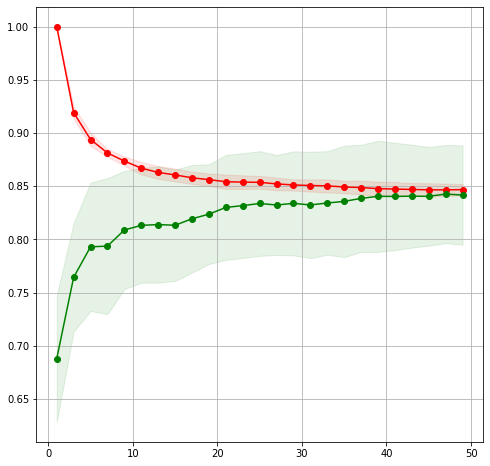

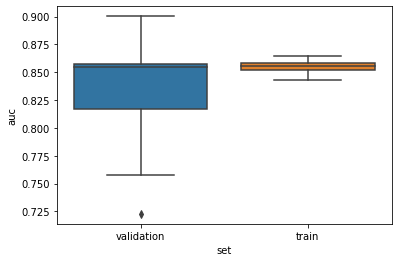

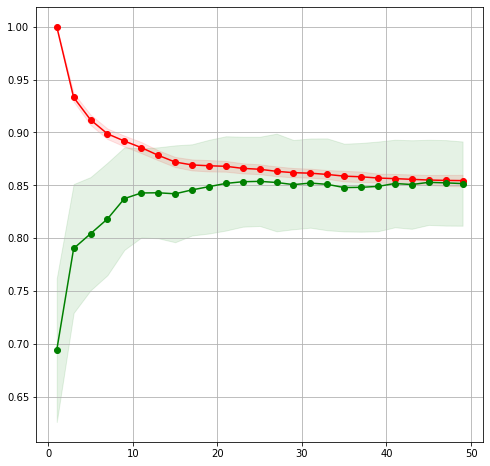

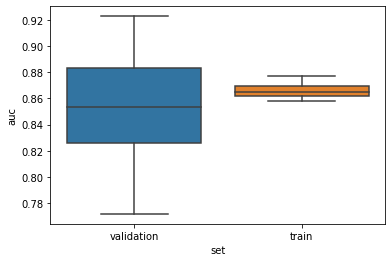

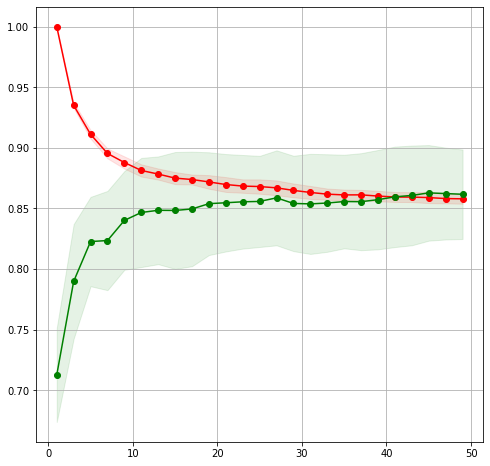

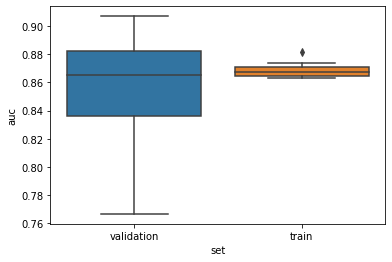

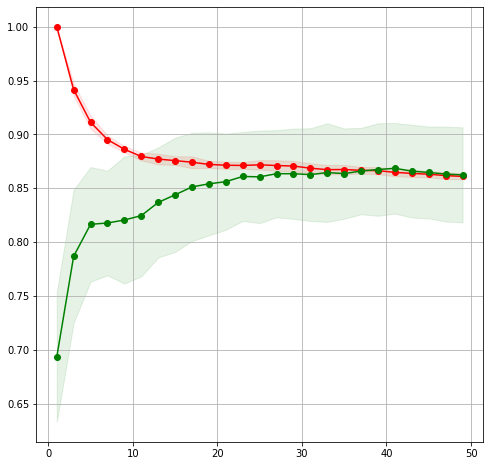

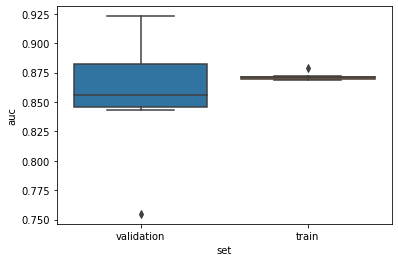

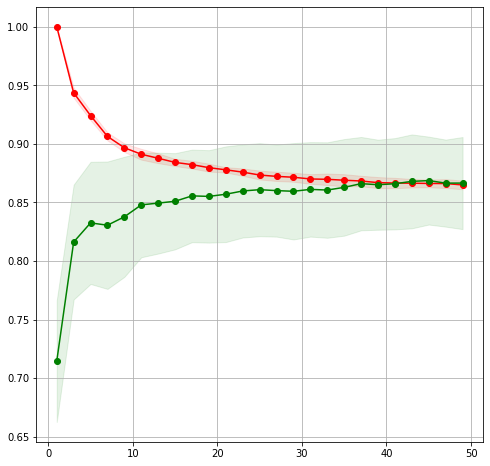

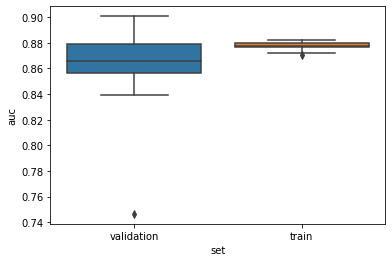

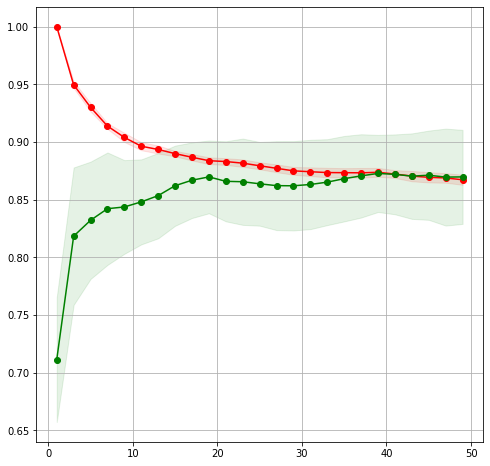

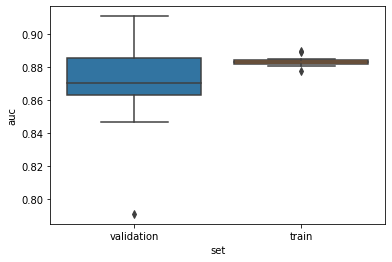

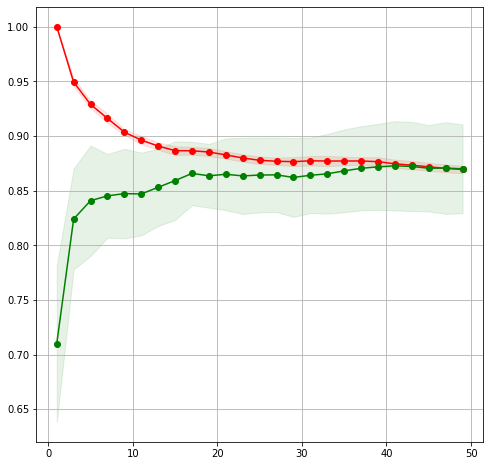

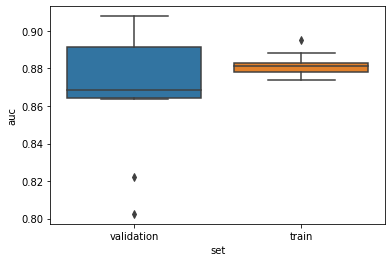

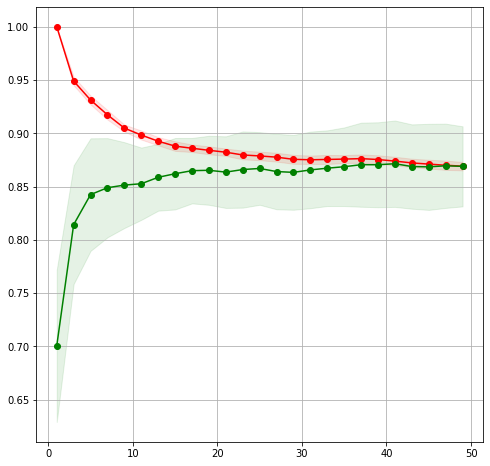

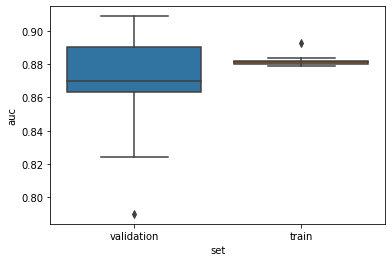

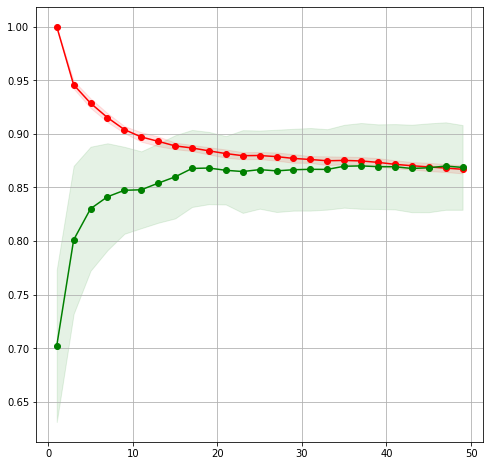

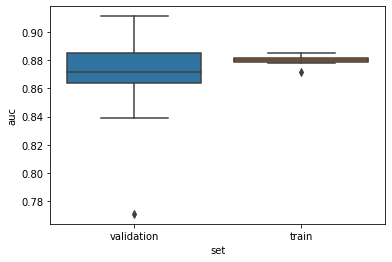

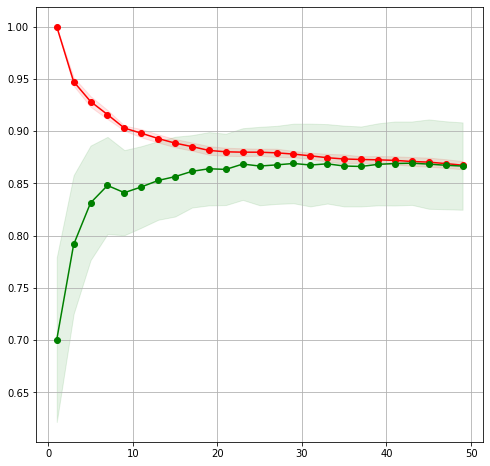

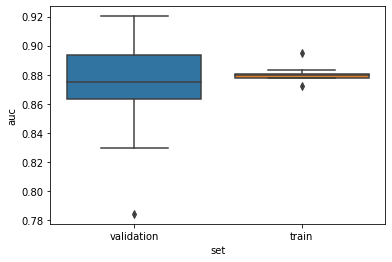

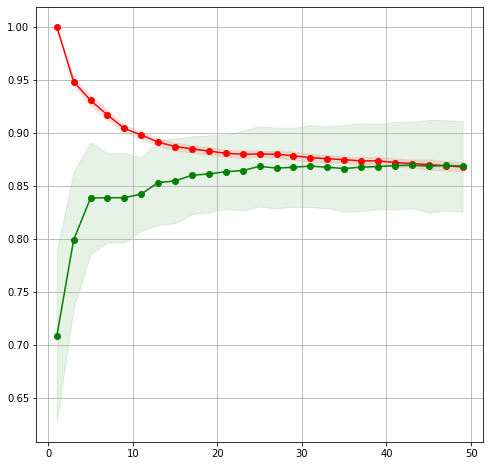

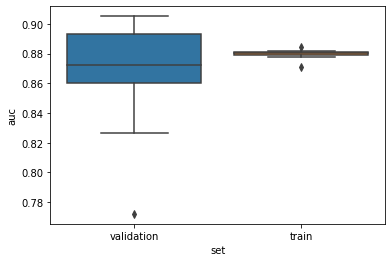

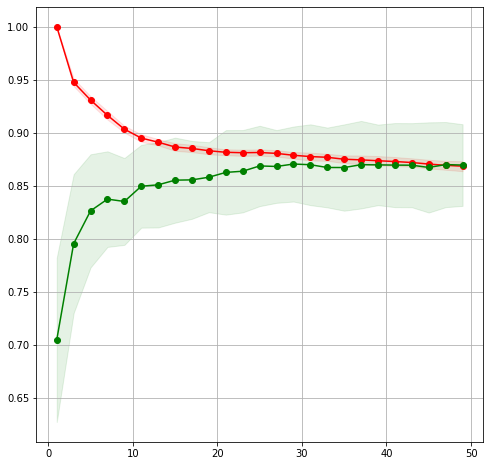

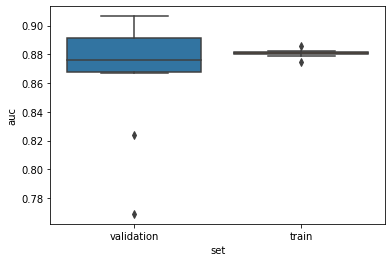

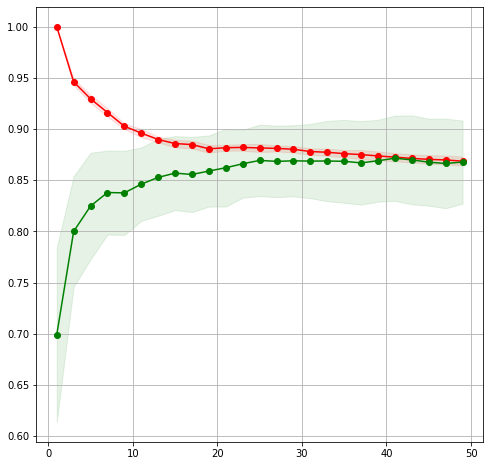

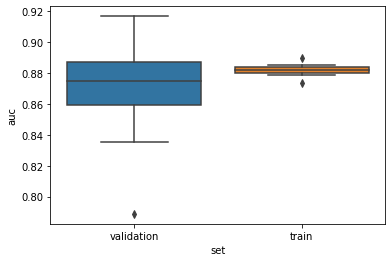

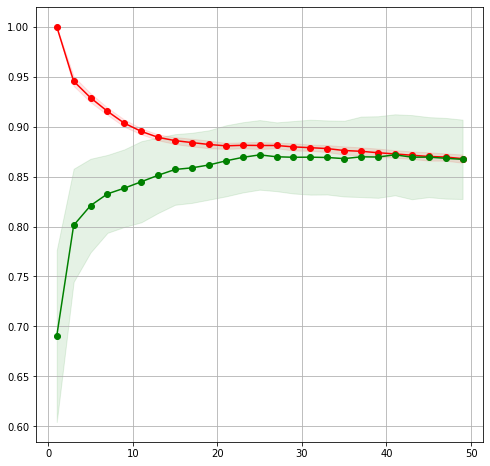

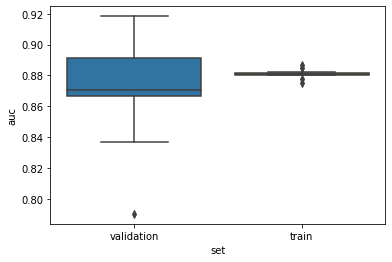

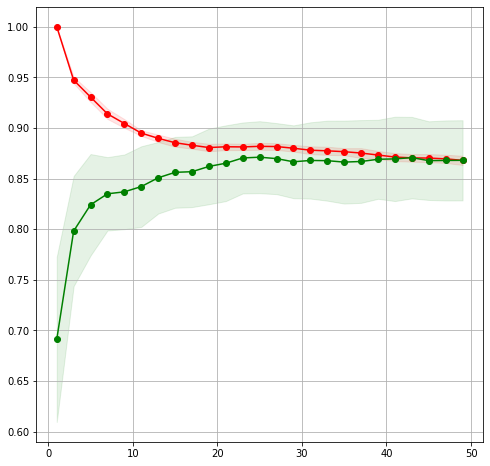

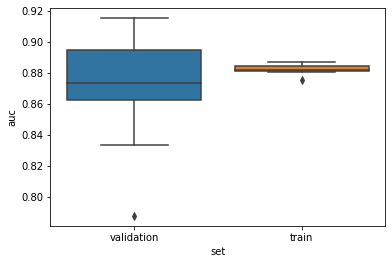

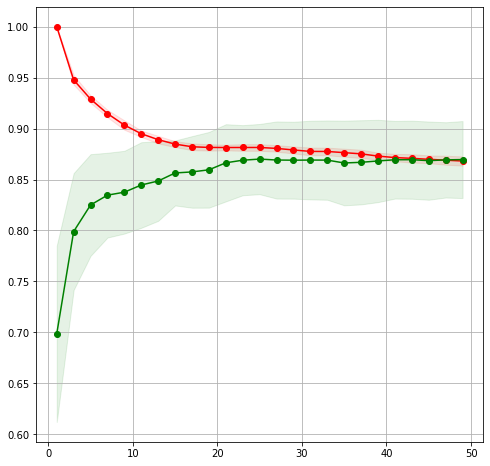

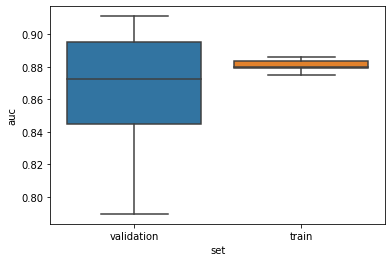

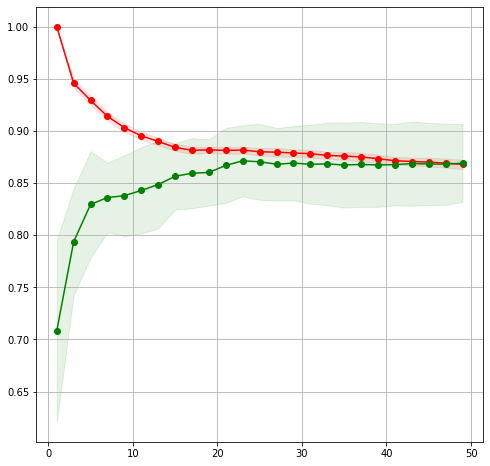

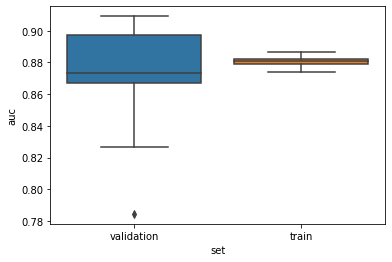

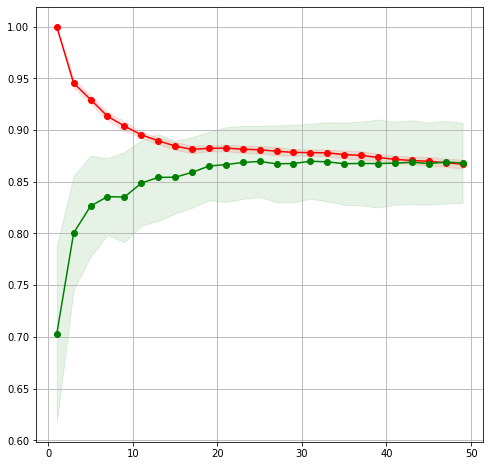

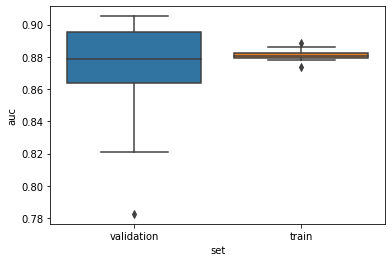

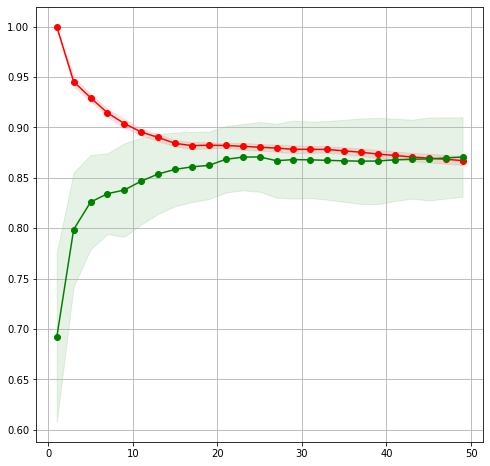

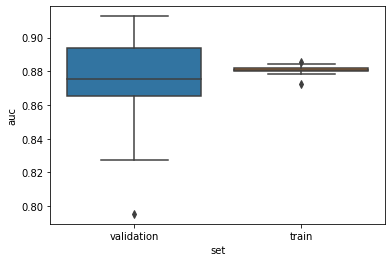

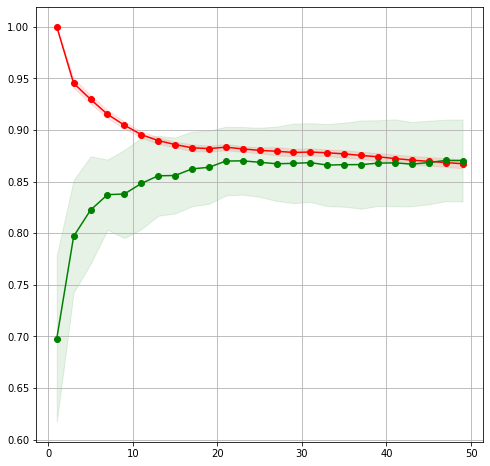

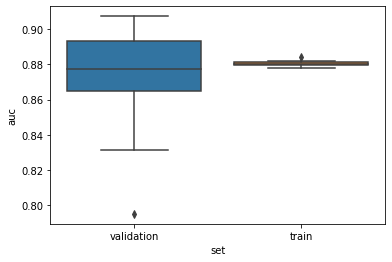

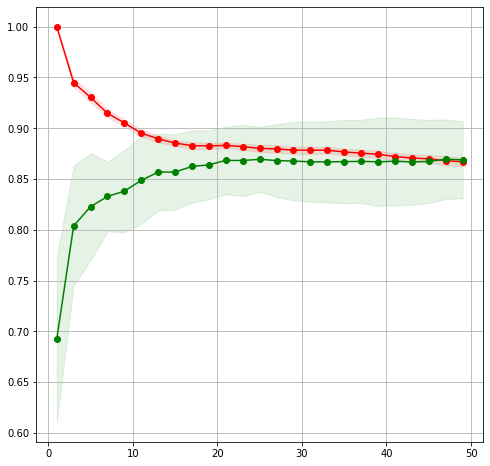

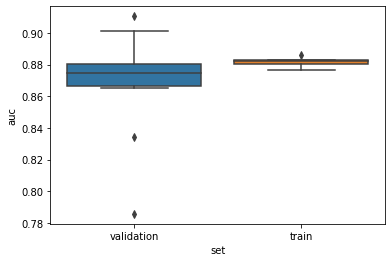

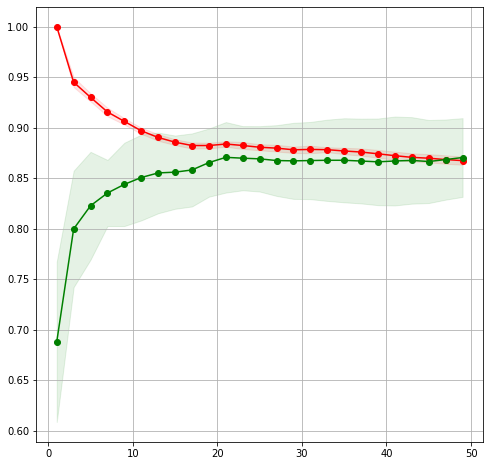

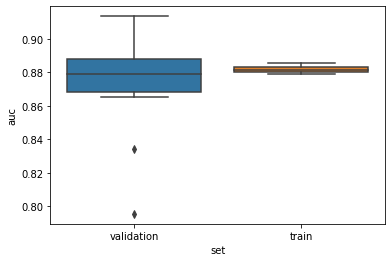

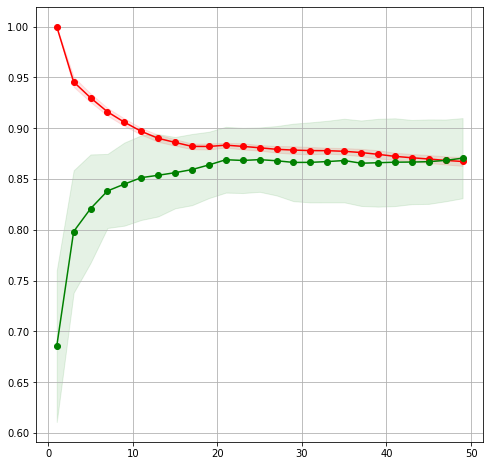

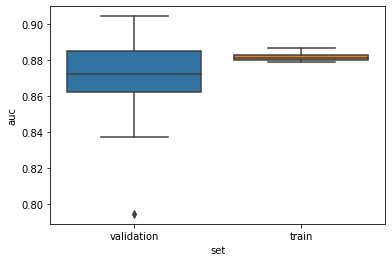

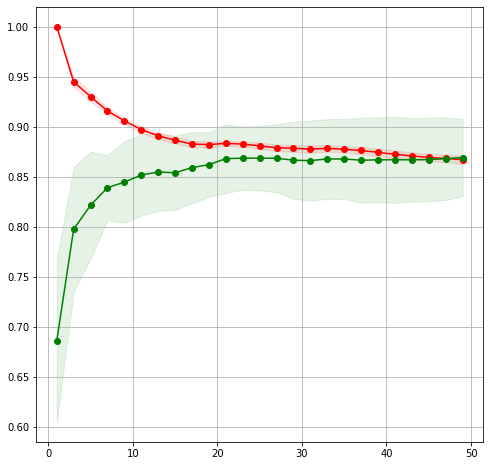

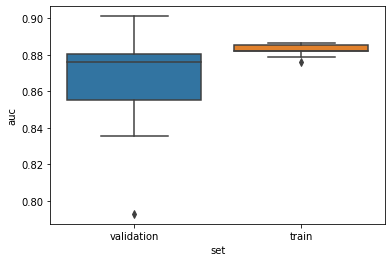

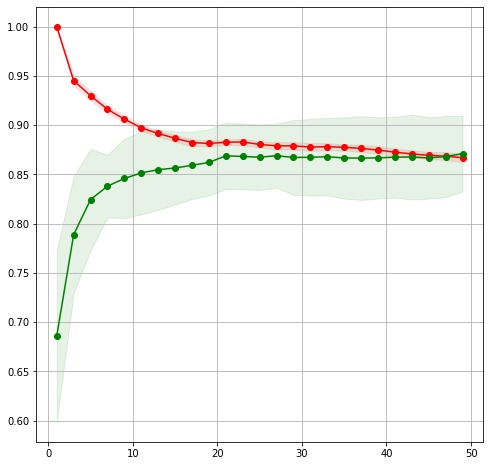

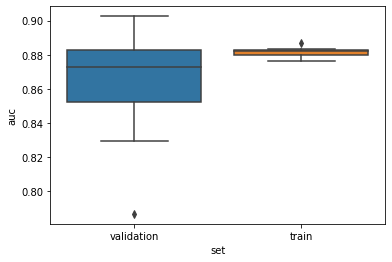

In [ ]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import StratifiedKFold, GridSearchCV, StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn import neighbors, metrics
import seaborn
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, f_classif
import math
from sklearn.decomposition import PCA
!pip install tabulate
from tabulate import tabulate

# configure the cross-validation procedure. A 10 fold split is used stratified for the label. 
sss = StratifiedShuffleSplit(n_splits = 10, test_size = 0.1, random_state=1)
k_list = list(range(1, 50, 2))
threshold = []
mean_auc_val = []
std_auc_val = []
optimal_k = []
n_pca = list(range(1,100,4))

for n_component in n_pca:
  
  all_train = []
  all_val = []
  results = []
  best_n_neighbors = []

  for train_idx, val_idx in sss.split(data_designset_norm,label_designset): # split data
    x_train, x_val = data_designset_norm.to_numpy()[train_idx], data_designset_norm.to_numpy()[val_idx]
    y_train, y_val = label_designset.to_numpy()[train_idx], label_designset.to_numpy()[val_idx]

    train_scores = []
    val_scores = []

    # Create a PCA which retains n principle components
    pca = PCA(n_components=n_component)

    # Fit the PCA model, point_data_train should be a 2D numpy array
    # which has one row per subject and the pointdata as columns where
    # the columns are x1, y1, z1, x2, y2, z2, ..., xn, yn, zn
    pca.fit(x_train)

    # Transform data and create the components of the data 
    selected_data_pca_trainset = pca.transform(x_train)
    selected_data_pca_valset = pca.transform(x_val)

    # Aplly K-Nearest Neighbor classifier to components generated with PCA 
    for k in k_list: 
      clf_knn = neighbors.KNeighborsClassifier(n_neighbors=k)
      clf_knn.fit(selected_data_pca_trainset, y_train)

      # Test the classifier on the selected features from the training data and plot 
      train_proba = clf_knn.predict_proba(selected_data_pca_trainset)[:,1]
      val_proba = clf_knn.predict_proba(selected_data_pca_valset)[:,1]

      score_train = metrics.roc_auc_score(y_train, train_proba)
      score_val = metrics.roc_auc_score(y_val, val_proba)

      train_scores.append(score_train)
      val_scores.append(score_val)

    all_train.append(train_scores)
    all_val.append(val_scores)

    # Create a grid search to find the optimal k using a gridsearch and 10-fold cross validation
    # Same as above
    parameters = {"n_neighbors": list(range(1, 26, 2))}
    knn = neighbors.KNeighborsClassifier()
    cv_10fold = StratifiedKFold(n_splits=10)
    grid_search = GridSearchCV(knn, parameters, cv=cv_10fold, scoring='roc_auc')
    grid_search.fit(selected_data_pca_trainset, y_train)
    
    # Get resulting classifier
    clf = grid_search.best_estimator_
    print(f'Best classifier: k={clf.n_neighbors}')
    best_n_neighbors.append(clf.n_neighbors)
    
    # Test the classifier on the test data
    probabilities = clf.predict_proba(selected_data_pca_valset)
    scores = probabilities[:, 1]
    
    # Get the auc
    auc = metrics.roc_auc_score(y_val, scores)
    results.append({
        'auc': auc,
        'k': clf.n_neighbors,
        'set': 'validation'
    })
     
    # Test the classifier on the validation data
    probabilities_train = clf.predict_proba(selected_data_pca_trainset)
    scores_train = probabilities_train[:, 1]
    
    # Get the auc
    auc_train = metrics.roc_auc_score(y_train, scores_train)
    results.append({
        'auc': auc_train,
        'k': clf.n_neighbors,
        'set': 'train'
    })
    
  # Calculate the mean and std
  all_train = np.array(all_train)
  all_val = np.array(all_val)

  train_scores_mean = all_train.mean(axis=0)
  val_scores_mean = all_val.mean(axis=0)

  train_scores_std = all_train.std(axis=0)
  val_scores_std = all_val.std(axis=0)

  # Plot the mean scores and the std as shading
  fig = plt.figure(figsize=(8,8))
  ax = fig.add_subplot(111)
  ax.grid()
  ax.fill_between(k_list, train_scores_mean - train_scores_std,
                      train_scores_mean + train_scores_std, alpha=0.1,
                      color="r")
  ax.fill_between(k_list, val_scores_mean - val_scores_std,
                      val_scores_mean + val_scores_std, alpha=0.1,
                      color="g")
  ax.plot(k_list, train_scores_mean, 'o-', color="r",
          label="Training score")
  ax.plot(k_list, val_scores_mean, 'o-', color="g",
          label="Validation score")
  
  # Create results dataframe and plot it
  plt.figure()
  results = pd.DataFrame(results)
  seaborn.boxplot(y='auc', x='set', data=results)

  optimal_n = int(np.median(best_n_neighbors))
  print(f"The optimal N={optimal_n}")

  auc_val = results[results['set'].str.contains('validation')]
  
  threshold.append(n_component)
  mean_auc_val.append(auc_val['auc'].mean())
  std_auc_val.append(auc_val['auc'].std())
  optimal_k.append(int(np.median(best_n_neighbors)))
    
auc_table = {'Number of Components': threshold, 'Mean AUC': mean_auc_val, 'Standard deviation AUC': std_auc_val, 'Optimal k': optimal_k}
print(tabulate(auc_table, headers='keys', tablefmt='fancy_grid'))

# Best values are n_components 21 and 20 k-NN

# SVM + univariate

In [32]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import StratifiedKFold, GridSearchCV, StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, classification_report
from sklearn import neighbors, metrics
from sklearn.svm import SVC
import seaborn
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, f_classif
import math
import seaborn as sns

kernels = ['Polynomial', 'RBF', 'Sigmoid','Linear']#A function which returns the corresponding SVC model
def getClassifier(ktype):
  if ktype == 0:
      # Polynomial kernal
      return SVC(kernel='poly', degree=8, gamma="auto")
  elif ktype == 1:
      # Radial Basis Function kernal
      return SVC(kernel='rbf', gamma="auto")
  elif ktype == 2:
      # Sigmoid kernal
      return SVC(kernel='sigmoid', gamma="auto")
  elif ktype == 3:
      # Linear kernal
      return SVC(kernel='linear', gamma="auto")

# configure the cross-validation procedure. A 10 fold split is used stratified for the label. 
sss = StratifiedShuffleSplit(n_splits = 10, test_size = 0.1, random_state=1)
for ker in range(4):
  for train_idx, val_idx in sss.split(data_designset_norm,label_designset): # split data
    x_train, x_val = data_designset_norm.to_numpy()[train_idx], data_designset_norm.to_numpy()[val_idx]
    y_train, y_val = label_designset.to_numpy()[train_idx], label_designset.to_numpy()[val_idx]

    # Feature selection using univariate statistical testing. An one-way ANOVA is used and the features are scored. 
    bestfeatures = SelectKBest(score_func=f_classif, k=len(data_designset_norm.columns))
    fit = bestfeatures.fit(x_train, y_train)
    dfscores = pd.DataFrame(fit.scores_)
    dfcolumns = pd.DataFrame(data_designset_norm.columns)

    feature_scores = pd.concat([dfcolumns,dfscores],axis=1)
    feature_scores.columns = ['Specs','Score']  
    feature_scores = feature_scores.sort_values('Score')
    highest_feature_score = feature_scores['Score'].iloc[-1]
    threshold_feature_relative = 0.7
    threshold_feature_score = threshold_feature_relative*highest_feature_score

    # Every feature scoring above the threshold will be selected. 
    feature_selection_names = []
    for i in range(0,len(feature_scores['Score'])):
      if feature_scores['Score'].iloc[i]>=threshold_feature_score:
        feature_selection_names.append(feature_scores['Specs'].iloc[i])

    selected_data_univ_designset_norm = data_designset_norm[feature_selection_names]
    selected_data_univ_trainset_norm = selected_data_univ_designset_norm.to_numpy()[train_idx]
    selected_data_univ_valset_norm = selected_data_univ_designset_norm.to_numpy()[val_idx]

  svclassifier = getClassifier(ker) 
  svclassifier.fit(selected_data_univ_trainset_norm, y_train)# Make prediction
  y_pred = svclassifier.predict(selected_data_univ_valset_norm)# Evaluate our model
  print("Evaluation:", kernels[ker], "kernel")
  print(classification_report(y_val,y_pred))




Evaluation: Polynomial kernel
              precision    recall  f1-score   support

          AD       0.61      1.00      0.76        42
          CN       0.00      0.00      0.00        27

    accuracy                           0.61        69
   macro avg       0.30      0.50      0.38        69
weighted avg       0.37      0.61      0.46        69

Evaluation:

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 RBF kernel
              precision    recall  f1-score   support

          AD       0.86      0.86      0.86        42
          CN       0.78      0.78      0.78        27

    accuracy                           0.83        69
   macro avg       0.82      0.82      0.82        69
weighted avg       0.83      0.83      0.83        69

Evaluation: Sigmoid kernel
              precision    recall  f1-score   support

          AD       0.86      0.86      0.86        42
          CN       0.78      0.78      0.78        27

    accuracy                           0.83        69
   macro avg       0.82      0.82      0.82        69
weighted avg       0.83      0.83      0.83        69

Evaluation: Linear kernel
              precision    recall  f1-score   support

          AD       0.86      0.86      0.86        42
          CN       0.78      0.78      0.78        27

    accuracy                           0.83        69
   macro avg       0.82      0.82      0.82        69
weighted 

In [39]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import StratifiedKFold, GridSearchCV, StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, classification_report
from sklearn import neighbors, metrics
from sklearn.svm import SVC
import seaborn
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, f_classif
import math

# configure the cross-validation procedure. A 10 fold split is used stratified for the label. 
sss = StratifiedShuffleSplit(n_splits = 10, test_size = 0.1, random_state=1)

threshold = []
mean_auc_val = []
std_auc_val = []
optimal_k = []

#thresholds = np.linspace(0,1,11)
#for threshold_feature_relative in thresholds:
all_train = []
all_val = []
results = []
best_n_neighbors = []


for train_idx, val_idx in sss.split(data_designset_norm,label_designset): # split data
  x_train, x_val = data_designset_norm.to_numpy()[train_idx], data_designset_norm.to_numpy()[val_idx]
  y_train, y_val = label_designset.to_numpy()[train_idx], label_designset.to_numpy()[val_idx]

  train_scores = []
  val_scores = []

  # Feature selection using univariate statistical testing. An one-way ANOVA is used and the features are scored. 
  bestfeatures = SelectKBest(score_func=f_classif, k=len(data_designset_norm.columns))
  fit = bestfeatures.fit(x_train, y_train)
  dfscores = pd.DataFrame(fit.scores_)
  dfcolumns = pd.DataFrame(data_designset_norm.columns)

  feature_scores = pd.concat([dfcolumns,dfscores],axis=1)
  feature_scores.columns = ['Specs','Score']  
  feature_scores = feature_scores.sort_values('Score')
  highest_feature_score = feature_scores['Score'].iloc[-1]
  threshold_feature_relative = 0.7
  threshold_feature_score = threshold_feature_relative*highest_feature_score

  # Every feature scoring above the threshold will be selected. 
  feature_selection_names = []
  for i in range(0,len(feature_scores['Score'])):
    if feature_scores['Score'].iloc[i]>=threshold_feature_score:
      feature_selection_names.append(feature_scores['Specs'].iloc[i])

  selected_data_univ_designset_norm = data_designset_norm[feature_selection_names]
  selected_data_univ_trainset_norm = selected_data_univ_designset_norm.to_numpy()[train_idx]
  selected_data_univ_valset_norm = selected_data_univ_designset_norm.to_numpy()[val_idx]
  
  # defining parameter range
  param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['linear', 'rbf', 'poly', 'sigmoid']}
  grid_search_svm = GridSearchCV(SVC(), param_grid, refit = True, verbose = 1)

  # fitting the model for grid search
  grid_search_svm.fit(selected_data_univ_trainset_norm, y_train)
  #print(grid_search_svm.best_params_)
  print(grid_search_svm.best_estimator_)

  grid_predictions = grid_search_svm.predict(selected_data_univ_valset_norm)
  print(classification_report(y_val,grid_predictions))


Fitting 5 folds for each of 64 candidates, totalling 320 fits
SVC(C=1, gamma=1, kernel='sigmoid')
              precision    recall  f1-score   support

          AD       0.89      0.74      0.81        42
          CN       0.68      0.85      0.75        27

    accuracy                           0.78        69
   macro avg       0.78      0.79      0.78        69
weighted avg       0.80      0.78      0.79        69

Fitting 5 folds for each of 64 candidates, totalling 320 fits
SVC(C=1, gamma=1)
              precision    recall  f1-score   support

          AD       0.76      0.83      0.80        42
          CN       0.70      0.59      0.64        27

    accuracy                           0.74        69
   macro avg       0.73      0.71      0.72        69
weighted avg       0.74      0.74      0.73        69

Fitting 5 folds for each of 64 candidates, totalling 320 fits
SVC(C=10, gamma=1, kernel='linear')
              precision    recall  f1-score   support

          AD   